In [137]:
from fastai.imports import *
from fastai.structured import *
from sklearn import cross_validation, metrics   #Additional scklearn functions
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import gzip
import warnings
warnings.filterwarnings(category=DeprecationWarning,action='ignore')

%matplotlib inline

### Reading processed data  

In [138]:
train_raw = pd.read_csv('intermediate_data/raw_train.csv')
test_raw = pd.read_csv('intermediate_data/raw_test.csv')

In [139]:
x_trn2 = pd.read_csv('intermediate_data/x_trn2.csv')
x_val2 = pd.read_csv('intermediate_data/x_val2.csv')
y_trn2 = np.load('intermediate_data/y_trn2.npy')
y_val2 = np.load('intermediate_data/y_val2.npy')
train_enc = pd.read_csv('intermediate_data/train_enc.csv')
test_enc = pd.read_csv('intermediate_data/test_enc.csv')

In [140]:
x_val2.shape, y_val2.shape

((8680, 33), (8680,))

In [141]:
x_trn2.shape, y_trn2.shape

((34720, 33), (34720,))

### Functions

In [142]:
scale_pos = sum(train_enc.stroke==0)/sum(train_enc.stroke==1)

In [143]:
scale_pos

54.427841634738186

In [144]:
def modelfit(alg, x_train, y_train, x_val=None, y_val=None, useTrainCV=True, cv_folds=5,rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train.values, label=y_train)
        
        cvresult = xgb.cv(xgb_param,
                          xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics = 'auc',
                         # feval = xg_fbeta, 
                          early_stopping_rounds = rounds, 
                          verbose_eval=20,
                          maximize=True)
        
        print('Best Rounds: ',cvresult.shape[0])
        
        alg.set_params(n_estimators=cvresult.shape[0])
        
    
    #Fit the algorithm on the data
    alg.fit(x_train, y_train)
        
    #Predict training set:
    dtrain_predictions = alg.predict(x_train)
    dtrain_predprob = alg.predict_proba(x_train)[:,1]
    
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    if x_val is not None: 
        print("AUC Score (Validation): %f" % metrics.roc_auc_score(y_val, alg.predict_proba(x_val)[:,1]))
                    
    fig, ax = plt.subplots(figsize=(6,12))
    xgb.plot_importance(alg, max_num_features=50, height=0.4, ax=ax)
    plt.show()

### Step 1: Tuning n_estimators

In [145]:
# target = 'stroke'
# predictors = [x for x in train_enc.columns if x not in [target]]

In [146]:
select_cols = ['avg_glucose_level_mean_ever_married',
 'gender',
 'bmi_mean_ever_married',
 'work_type',
 'smoking_status',
 'bmi_mean_hypertension',
 'avg_glucose_level_mean_hypertension',
 'avg_glucose_level_mean_smoking_status',
 'age_bins',
 'stroke_mean_age_bins',
 'avg_glucose_level_mean_age_bins',
 'avg_glucose_level',
 'bmi',
 'age']

In [148]:
x_trn3 = train_raw.drop(['stroke', 'age_bins'], axis=1)
y_trn3 = train_raw['stroke'].values

In [216]:
cols = ['heart_disease', 'id', 'bmi', 'avg_glucose_level', 'age']
x_trn3 = x_trn3[cols]

[0]	train-auc:0.859797+0.00447646	test-auc:0.82668+0.0143519
[20]	train-auc:0.887639+0.00414564	test-auc:0.847331+0.0176375
[40]	train-auc:0.892695+0.00373505	test-auc:0.847304+0.0177808
[60]	train-auc:0.896881+0.00339194	test-auc:0.848247+0.0168887
[80]	train-auc:0.900841+0.00299178	test-auc:0.849018+0.0164563
[100]	train-auc:0.904384+0.00269029	test-auc:0.8491+0.0159568
[120]	train-auc:0.907654+0.00233558	test-auc:0.849586+0.0162626
[140]	train-auc:0.911318+0.00233531	test-auc:0.84974+0.0156555
[160]	train-auc:0.914782+0.00214407	test-auc:0.849884+0.0154521
[180]	train-auc:0.918289+0.00213988	test-auc:0.849587+0.0152655
[200]	train-auc:0.921755+0.00161617	test-auc:0.849004+0.0149567
Best Rounds:  157

Model Report
Accuracy : 0.7824
AUC Score (Train): 0.907189


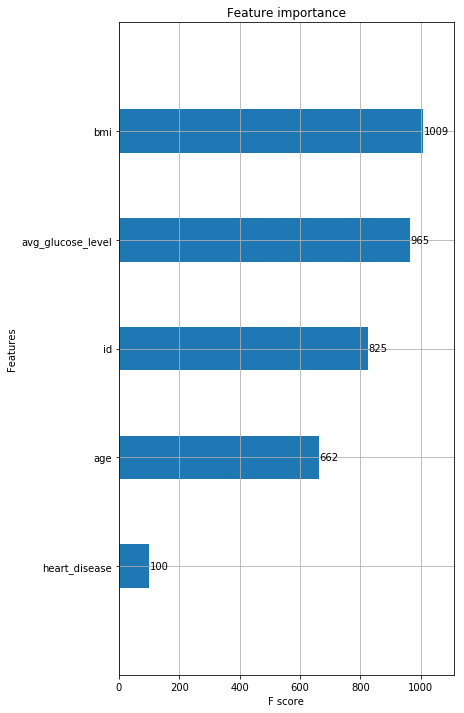

In [218]:
xgb1 = XGBClassifier(n_jobs=-1,
 learning_rate =.025,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=scale_pos,
 seed=1)
#modelfit(xgb1, x_trn2[select_cols], y_trn2, x_val2[select_cols], y_val2)
modelfit(xgb1, x_trn3, y_trn3)

### Step 2 Tuning for max_depth and  min_child_weight

In [219]:
xgbreg = XGBClassifier(learning_rate =.025, 
                       n_estimators=157, 
                       max_depth=5,
                       min_child_weight=1, 
                       gamma=0, 
                       subsample=0.8,
                       colsample_bytree=0.8,
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=scale_pos, 
                       seed=1)

In [220]:

grid1 = {'max_depth':range(3,10,2),
         'min_child_weight':range(1,6,2)
}

gs1 = GridSearchCV(xgbreg, 
                   grid1,
                   n_jobs=-1, 
                   verbose=20,
                   #objective= 'binary:logistic',
                   scoring='roc_auc',
                   cv = StratifiedKFold(n_splits=5, 
                                   shuffle=True,
                                   random_state=1).split(x_trn3,y_trn3),
                   iid=False)  

gs1.fit(x_trn3, y_trn3)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV]  max_depth=3, min_child_weight=1, score=0.8396894344032735, total=   5.4s
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.7s


[CV]  max_depth=3, min_child_weight=1, score=0.8486455906871702, total=   5.6s
[CV]  max_depth=3, min_child_weight=1, score=0.8559010601762875, total=   5.6s
[CV]  max_depth=3, min_child_weight=1, score=0.8606666125145533, total=   5.7s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] max_depth=3, min_child_weight=3 .................................
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.1s


[CV]  max_depth=3, min_child_weight=1, score=0.8678365027361858, total=   6.1s
[CV] max_depth=3, min_child_weight=3 .................................
[CV]  max_depth=3, min_child_weight=3, score=0.8560172551387315, total=   5.8s


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   12.1s


[CV]  max_depth=3, min_child_weight=3, score=0.8396819620584217, total=   6.0s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] max_depth=3, min_child_weight=5 .................................
[CV]  max_depth=3, min_child_weight=3, score=0.8487076184262741, total=   6.1s


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.4s


[CV] max_depth=3, min_child_weight=5 .................................
[CV]  max_depth=3, min_child_weight=3, score=0.8608106420936411, total=   5.6s
[CV] max_depth=3, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.8s


[CV]  max_depth=3, min_child_weight=3, score=0.8678282294966561, total=   5.5s
[CV]  max_depth=3, min_child_weight=5, score=0.8567099415064846, total=   5.6s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] max_depth=3, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   18.1s


[CV]  max_depth=3, min_child_weight=5, score=0.8401037759253005, total=   5.8s
[CV] max_depth=5, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   18.5s


[CV]  max_depth=3, min_child_weight=5, score=0.8490289669541615, total=   5.1s
[CV] max_depth=5, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   23.0s


[CV]  max_depth=3, min_child_weight=5, score=0.8627413153548318, total=   5.1s
[CV] max_depth=5, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   23.4s


[CV]  max_depth=3, min_child_weight=5, score=0.8676834478048839, total=   5.3s
[CV] max_depth=5, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   23.7s


[CV]  max_depth=5, min_child_weight=1, score=0.8476482289048232, total=   8.2s
[CV] max_depth=5, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   27.0s


[CV]  max_depth=5, min_child_weight=1, score=0.8368615254941462, total=   8.3s
[CV] max_depth=5, min_child_weight=3 .................................
[CV]  max_depth=5, min_child_weight=1, score=0.8440958933900102, total=   8.0s


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   31.8s


[CV] max_depth=5, min_child_weight=3 .................................
[CV]  max_depth=5, min_child_weight=1, score=0.8560008814760662, total=   8.2s
[CV] max_depth=5, min_child_weight=3 .................................


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   32.1s


[CV]  max_depth=5, min_child_weight=1, score=0.8607008336416995, total=   8.2s
[CV] max_depth=5, min_child_weight=3 .................................


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:   35.5s


[CV]  max_depth=5, min_child_weight=3, score=0.84424386317727, total=   7.5s
[CV] max_depth=5, min_child_weight=3 .................................
[CV]  max_depth=5, min_child_weight=3, score=0.8486525120528923, total=   8.1s


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:   40.2s


[CV] max_depth=5, min_child_weight=5 .................................
[CV]  max_depth=5, min_child_weight=3, score=0.8377593277280785, total=   8.3s
[CV] max_depth=5, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:   40.5s


[CV]  max_depth=5, min_child_weight=3, score=0.8560448800681114, total=   8.0s
[CV] max_depth=5, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   43.8s


[CV]  max_depth=5, min_child_weight=3, score=0.8593432702461213, total=   7.8s
[CV] max_depth=5, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   48.0s


[CV]  max_depth=5, min_child_weight=5, score=0.8493123201032977, total=   7.9s
[CV] max_depth=5, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   48.4s


[CV]  max_depth=5, min_child_weight=5, score=0.8365510495655579, total=   8.4s
[CV] max_depth=7, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   49.2s


[CV]  max_depth=5, min_child_weight=5, score=0.8451892257069855, total=   7.7s
[CV] max_depth=7, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   51.8s


[CV]  max_depth=5, min_child_weight=5, score=0.8584253167146514, total=   7.9s
[CV] max_depth=7, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   56.4s


[CV]  max_depth=5, min_child_weight=5, score=0.8579563744558465, total=   8.1s
[CV] max_depth=7, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   56.7s


[CV]  max_depth=7, min_child_weight=1, score=0.8407516282239431, total=  11.0s
[CV] max_depth=7, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:  1.0min


[CV]  max_depth=7, min_child_weight=1, score=0.8307947287090478, total=  11.0s
[CV] max_depth=7, min_child_weight=3 .................................


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:  1.1min


[CV]  max_depth=7, min_child_weight=1, score=0.8369709239368035, total=  10.6s
[CV] max_depth=7, min_child_weight=3 .................................


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min


[CV]  max_depth=7, min_child_weight=1, score=0.844742506701324, total=  11.1s
[CV] max_depth=7, min_child_weight=3 .................................


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min


[CV]  max_depth=7, min_child_weight=1, score=0.8524166884779345, total=  10.5s
[CV] max_depth=7, min_child_weight=3 .................................


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:  1.2min


[CV]  max_depth=7, min_child_weight=3, score=0.8439875271619734, total=  11.2s
[CV] max_depth=7, min_child_weight=3 .................................


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:  1.2min


[CV]  max_depth=7, min_child_weight=3, score=0.8307663337986113, total=  10.6s
[CV] max_depth=7, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


[CV]  max_depth=7, min_child_weight=3, score=0.8380978857508832, total=  11.0s
[CV] max_depth=7, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.3min


[CV]  max_depth=7, min_child_weight=3, score=0.8459917658703298, total=  10.6s
[CV] max_depth=7, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:  1.4min


[CV]  max_depth=7, min_child_weight=3, score=0.8504551785966781, total=  10.8s
[CV] max_depth=7, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.4min


[CV]  max_depth=7, min_child_weight=5, score=0.8432600943906602, total=  11.2s
[CV] max_depth=7, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:  1.5min


[CV]  max_depth=7, min_child_weight=5, score=0.8288735888476748, total=  11.1s
[CV] max_depth=9, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min


[CV]  max_depth=7, min_child_weight=5, score=0.8354598385335745, total=  10.6s
[CV] max_depth=9, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:  1.6min


[CV]  max_depth=7, min_child_weight=5, score=0.849429296894978, total=  10.9s
[CV] max_depth=9, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:  1.6min


[CV]  max_depth=7, min_child_weight=5, score=0.8499399814077744, total=  11.0s
[CV] max_depth=9, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.7min


[CV]  max_depth=9, min_child_weight=1, score=0.8363504171062897, total=  14.0s
[CV] max_depth=9, min_child_weight=1 .................................


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min


[CV]  max_depth=9, min_child_weight=1, score=0.8250996810803217, total=  13.7s
[CV] max_depth=9, min_child_weight=3 .................................


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:  1.8min


[CV]  max_depth=9, min_child_weight=1, score=0.833439079418673, total=  13.6s
[CV] max_depth=9, min_child_weight=3 .................................


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.9min


[CV]  max_depth=9, min_child_weight=1, score=0.8386906319852465, total=  13.6s
[CV] max_depth=9, min_child_weight=3 .................................


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  1.9min


[CV]  max_depth=9, min_child_weight=1, score=0.8421714094892554, total=  13.8s
[CV] max_depth=9, min_child_weight=3 .................................


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  2.0min


[CV]  max_depth=9, min_child_weight=3, score=0.8369997638739026, total=  14.4s
[CV] max_depth=9, min_child_weight=3 .................................


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:  2.0min


[CV]  max_depth=9, min_child_weight=3, score=0.819375491306674, total=  14.0s
[CV] max_depth=9, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:  2.1min


[CV]  max_depth=9, min_child_weight=3, score=0.8312613826506171, total=  13.7s
[CV] max_depth=9, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.2min


[CV]  max_depth=9, min_child_weight=3, score=0.8379753728222576, total=  13.9s
[CV] max_depth=9, min_child_weight=5 .................................
[CV]  max_depth=9, min_child_weight=3, score=0.8415682151162616, total=  14.0s
[CV] max_depth=9, min_child_weight=5 .................................
[CV]  max_depth=9, min_child_weight=5, score=0.8389126841559389, total=  15.0s
[CV] max_depth=9, min_child_weight=5 .................................
[CV]  max_depth=9, min_child_weight=5, score=0.819033257912466, total=  14.7s


[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:  2.4min remaining:    7.6s


[CV]  max_depth=9, min_child_weight=5, score=0.8318726921757611, total=  13.2s
[CV]  max_depth=9, min_child_weight=5, score=0.8413794348324444, total=  12.4s
[CV]  max_depth=9, min_child_weight=5, score=0.8402986489047735, total=   9.2s


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.5min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x1c2e3f1150>,
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.025,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=157, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=54.427841634738186, seed=1, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=20)

In [221]:
# print("AUC Score (Validation): %f" % metrics.roc_auc_score(y_val2, gs1.best_estimator_.predict_proba(x_val2[select_cols])[:,1]))

In [223]:
gs1.grid_scores_, gs1.best_params_, gs1.best_score_

([mean: 0.85455, std: 0.00971, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.85461, std: 0.00972, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.85525, std: 0.00981, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.84906, std: 0.00847, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.84921, std: 0.00782, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84949, std: 0.00822, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.84114, std: 0.00728, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.84186, std: 0.00682, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.84139, std: 0.00816, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.83515, std: 0.00578, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.83344, std: 0.00777, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.83430, std: 0.00832, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 5

Fine tuning 

In [224]:
grid2 = {'max_depth':[2,3,4],
         'min_child_weight':[4,5,6] 
}

gs2 = GridSearchCV(xgbreg, 
                   grid2,
                   n_jobs=-1, 
                   verbose=20,
                   scoring='roc_auc',
                   cv = StratifiedKFold(n_splits=5, 
                                   shuffle=True,
                                   random_state=1).split(x_trn3,y_trn3),
                            iid=False) 

gs2.fit(x_trn3, y_trn3)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=2, min_child_weight=4 .................................
[CV] max_depth=2, min_child_weight=4 .................................
[CV] max_depth=2, min_child_weight=4 .................................
[CV] max_depth=2, min_child_weight=4 .................................
[CV]  max_depth=2, min_child_weight=4, score=0.857380256139496, total=   3.9s
[CV] max_depth=2, min_child_weight=4 .................................
[CV]  max_depth=2, min_child_weight=4, score=0.8386623606034069, total=   4.0s
[CV]  max_depth=2, min_child_weight=4, score=0.8447352274960747, total=   4.1s


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.3s


[CV]  max_depth=2, min_child_weight=4, score=0.8544921495544988, total=   4.2s
[CV] max_depth=2, min_child_weight=5 .................................
[CV] max_depth=2, min_child_weight=5 .................................
[CV] max_depth=2, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.4s


[CV]  max_depth=2, min_child_weight=5, score=0.8381833832984127, total=   3.5s
[CV] max_depth=2, min_child_weight=5 .................................
[CV]  max_depth=2, min_child_weight=4, score=0.8622975688709584, total=   3.8s
[CV]  max_depth=2, min_child_weight=5, score=0.8545100831821428, total=   3.6s
[CV]  max_depth=2, min_child_weight=5, score=0.8447352274960747, total=   3.6s
[CV] max_depth=2, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.2s


[CV] max_depth=2, min_child_weight=6 .................................
[CV] max_depth=2, min_child_weight=6 .................................
[CV]  max_depth=2, min_child_weight=6, score=0.8545100831821428, total=   3.2s
[CV] max_depth=2, min_child_weight=6 .................................
[CV]  max_depth=2, min_child_weight=5, score=0.857380256139496, total=   3.5s


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.8s


[CV] max_depth=2, min_child_weight=6 .................................
[CV]  max_depth=2, min_child_weight=5, score=0.8622975688709584, total=   3.6s
[CV]  max_depth=2, min_child_weight=6, score=0.8381613398811001, total=   3.4s
[CV] max_depth=2, min_child_weight=6 .................................
[CV] max_depth=3, min_child_weight=4 .................................


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   11.9s


[CV]  max_depth=2, min_child_weight=6, score=0.8446739470791287, total=   3.4s
[CV] max_depth=3, min_child_weight=4 .................................
[CV]  max_depth=2, min_child_weight=6, score=0.8573885293790258, total=   3.3s


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   15.3s


[CV] max_depth=3, min_child_weight=4 .................................
[CV]  max_depth=2, min_child_weight=6, score=0.8622975688709584, total=   3.7s
[CV] max_depth=3, min_child_weight=4 .................................


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   15.8s


[CV]  max_depth=3, min_child_weight=4, score=0.8562040637600241, total=   4.9s
[CV] max_depth=3, min_child_weight=4 .................................


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.9s


[CV]  max_depth=3, min_child_weight=4, score=0.8396602922583518, total=   5.2s
[CV] max_depth=3, min_child_weight=5 .................................
[CV]  max_depth=3, min_child_weight=4, score=0.84902597766553, total=   5.1s


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   20.7s


[CV] max_depth=3, min_child_weight=5 .................................
[CV]  max_depth=3, min_child_weight=4, score=0.8625555435217526, total=   5.1s
[CV] max_depth=3, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   21.0s


[CV]  max_depth=3, min_child_weight=4, score=0.8675804083671033, total=   5.1s
[CV] max_depth=3, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:   22.1s


[CV]  max_depth=3, min_child_weight=5, score=0.8567099415064846, total=   5.1s
[CV] max_depth=3, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   25.8s


[CV]  max_depth=3, min_child_weight=5, score=0.8401037759253005, total=   5.1s
[CV] max_depth=3, min_child_weight=6 .................................


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:   26.1s


[CV]  max_depth=3, min_child_weight=5, score=0.8490289669541615, total=   5.5s
[CV] max_depth=3, min_child_weight=6 .................................


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:   26.6s


[CV]  max_depth=3, min_child_weight=5, score=0.8627413153548318, total=   5.1s
[CV] max_depth=3, min_child_weight=6 .................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.4s


[CV]  max_depth=3, min_child_weight=5, score=0.8676834478048839, total=   5.2s
[CV] max_depth=3, min_child_weight=6 .................................
[CV]  max_depth=3, min_child_weight=6, score=0.8562701940119617, total=   4.9s
[CV] max_depth=3, min_child_weight=6 .................................


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.2s


[CV]  max_depth=3, min_child_weight=6, score=0.839847474496887, total=   5.2s
[CV] max_depth=4, min_child_weight=4 .................................


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   32.0s


[CV]  max_depth=3, min_child_weight=6, score=0.8488522252638234, total=   5.2s
[CV] max_depth=4, min_child_weight=4 .................................


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   32.8s


[CV]  max_depth=3, min_child_weight=6, score=0.8630248618368999, total=   5.5s
[CV] max_depth=4, min_child_weight=4 .................................
[CV]  max_depth=3, min_child_weight=6, score=0.8677375999181701, total=   5.6s


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   37.0s


[CV] max_depth=4, min_child_weight=4 .................................
[CV]  max_depth=4, min_child_weight=4, score=0.8518592688460009, total=   7.7s
[CV] max_depth=4, min_child_weight=4 .................................


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   39.9s


[CV]  max_depth=4, min_child_weight=4, score=0.8393901669919628, total=   7.5s
[CV] max_depth=4, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   40.5s


[CV]  max_depth=4, min_child_weight=4, score=0.8476781821537974, total=   7.0s
[CV] max_depth=4, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.0s


[CV]  max_depth=4, min_child_weight=4, score=0.8600709392684049, total=   7.1s
[CV] max_depth=4, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.4s


[CV]  max_depth=4, min_child_weight=4, score=0.8640740590318203, total=   6.7s
[CV] max_depth=4, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   46.7s


[CV]  max_depth=4, min_child_weight=5, score=0.8515420678070462, total=   6.7s
[CV] max_depth=4, min_child_weight=5 .................................


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   47.6s


[CV]  max_depth=4, min_child_weight=5, score=0.8398721332348975, total=   6.5s
[CV] max_depth=4, min_child_weight=6 .................................


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   50.7s


[CV]  max_depth=4, min_child_weight=5, score=0.8477346049767172, total=   6.4s
[CV] max_depth=4, min_child_weight=6 .................................


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   51.0s


[CV]  max_depth=4, min_child_weight=5, score=0.8621080364744568, total=   6.5s
[CV] max_depth=4, min_child_weight=6 .................................
[CV]  max_depth=4, min_child_weight=5, score=0.8637006350839509, total=   6.5s
[CV] max_depth=4, min_child_weight=6 .................................
[CV]  max_depth=4, min_child_weight=6, score=0.8519168059013591, total=   6.8s
[CV] max_depth=4, min_child_weight=6 .................................


[Parallel(n_jobs=-1)]: Done  41 out of  45 | elapsed:   57.8s remaining:    5.6s


[CV]  max_depth=4, min_child_weight=6, score=0.8398280464002725, total=   7.0s
[CV]  max_depth=4, min_child_weight=6, score=0.8479588016240805, total=   6.9s
[CV]  max_depth=4, min_child_weight=6, score=0.8625491505639341, total=   6.6s
[CV]  max_depth=4, min_child_weight=6, score=0.8637717097326391, total=   4.4s


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.0min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x1c2e286410>,
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.025,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=157, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=54.427841634738186, seed=1, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4], 'min_child_weight': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=20)

In [225]:
# print("AUC Score (Validation): %f" % metrics.roc_auc_score(y_val2, gs2.best_estimator_.predict_proba(x_val2[select_cols])[:,1]))

In [227]:
gs2.grid_scores_, gs2.best_params_, gs2.best_score_

([mean: 0.85151, std: 0.00861, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.85142, std: 0.00876, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: 0.85141, std: 0.00877, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: 0.85501, std: 0.00988, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.85525, std: 0.00981, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.85515, std: 0.00996, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: 0.85261, std: 0.00879, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.85299, std: 0.00894, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.85320, std: 0.00902, params: {'max_depth': 4, 'min_child_weight': 6}],
 {'max_depth': 3, 'min_child_weight': 5},
 0.8552534895091325)

####  {'max_depth': 3, 'min_child_weight': 5},


### Step 3: Tune Gamma¶


In [228]:
xgbreg = XGBClassifier(learning_rate =.025, # fixed
                       n_estimators=157, # pre-tuned
                       max_depth=3, # tuned
                       min_child_weight=5, # tuned 
                       gamma=0, # now
                       subsample=0.8,
                       colsample_bytree=0.8,
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=scale_pos, 
                       seed=1)

In [229]:
grid3 = {
    'gamma':[i/20.0 for i in range(0,10)]
}

gs3 = GridSearchCV(xgbreg, 
                   grid3,
                   n_jobs=-1, 
                   verbose=20,
                   scoring='roc_auc',
                   cv = StratifiedKFold(n_splits=5, 
                                   shuffle=True,
                                   random_state=1).split(x_trn3,y_trn3),
                            iid=False)  

gs3.fit(x_trn3, y_trn3)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] .............. gamma=0.0, score=0.8490289669541615, total=   4.9s
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s


[CV] .............. gamma=0.0, score=0.8567099415064846, total=   5.2s
[CV] .............. gamma=0.0, score=0.8627413153548318, total=   5.2s
[CV] gamma=0.05 ......................................................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.6s


[CV] gamma=0.05 ......................................................
[CV] .............. gamma=0.0, score=0.8401037759253005, total=   5.5s
[CV] gamma=0.05 ......................................................


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.7s


[CV] .............. gamma=0.0, score=0.8676834478048839, total=   6.2s
[CV] gamma=0.05 ......................................................
[CV] ............. gamma=0.05, score=0.8567099415064846, total=   6.0s
[CV] gamma=0.05 ......................................................


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   11.7s


[CV] ............. gamma=0.05, score=0.8401037759253005, total=   6.1s
[CV] gamma=0.1 .......................................................
[CV] ............. gamma=0.05, score=0.8490087892558988, total=   6.2s
[CV] gamma=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.2s


[CV] ............. gamma=0.05, score=0.8627413153548318, total=   6.1s
[CV] gamma=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.9s


[CV] .............. gamma=0.1, score=0.8567099415064846, total=   5.9s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.1, score=0.8401037759253005, total=   6.0s


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   18.4s


[CV] gamma=0.1 .......................................................
[CV] ............. gamma=0.05, score=0.8676834478048839, total=   6.6s
[CV] gamma=0.15 ......................................................


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   18.5s


[CV] .............. gamma=0.1, score=0.8490087892558988, total=   6.1s
[CV] gamma=0.15 ......................................................


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   24.1s


[CV] ............... gamma=0.1, score=0.862760118171945, total=   6.3s
[CV] gamma=0.15 ......................................................
[CV] .............. gamma=0.1, score=0.8676834478048839, total=   6.2s


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   24.9s


[CV] gamma=0.15 ......................................................
[CV] ............. gamma=0.15, score=0.8567099415064846, total=   6.3s
[CV] gamma=0.15 ......................................................


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   25.1s


[CV] ............. gamma=0.15, score=0.8401037759253005, total=   6.1s
[CV] gamma=0.2 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   30.5s


[CV] .............. gamma=0.15, score=0.862760118171945, total=   5.9s
[CV] ............. gamma=0.15, score=0.8490087892558988, total=   6.1s
[CV] gamma=0.2 .......................................................
[CV] gamma=0.2 .......................................................


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   31.0s


[CV] ............. gamma=0.15, score=0.8676834478048839, total=   5.9s
[CV] gamma=0.2 .......................................................


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:   31.3s


[CV] .............. gamma=0.2, score=0.8567073261857864, total=   6.1s
[CV] gamma=0.2 .......................................................


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   36.8s


[CV] .............. gamma=0.2, score=0.8490020633564779, total=   6.2s
[CV] gamma=0.25 ......................................................
[CV] .............. gamma=0.2, score=0.8401037759253005, total=   6.3s
[CV] gamma=0.25 ......................................................


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:   37.6s


[CV] ............... gamma=0.2, score=0.862760118171945, total=   6.4s
[CV] gamma=0.25 ......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   37.8s


[CV] .............. gamma=0.2, score=0.8676834478048839, total=   6.2s
[CV] gamma=0.25 ......................................................


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   43.2s


[CV] ............. gamma=0.25, score=0.8401037759253005, total=   6.1s
[CV] gamma=0.25 ......................................................


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   43.9s


[CV] ............. gamma=0.25, score=0.8567073261857864, total=   6.5s
[CV] gamma=0.3 .......................................................


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   44.2s


[CV] ............. gamma=0.25, score=0.8490020633564779, total=   6.4s
[CV] gamma=0.3 .......................................................


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   44.4s


[CV] .............. gamma=0.25, score=0.862760118171945, total=   6.0s
[CV] gamma=0.3 .......................................................


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   49.3s


[CV] ............. gamma=0.25, score=0.8676834478048839, total=   6.1s
[CV] gamma=0.3 .......................................................


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   50.1s


[CV] .............. gamma=0.3, score=0.8567073261857864, total=   6.0s
[CV] gamma=0.3 .......................................................


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   50.3s


[CV] .............. gamma=0.3, score=0.8401037759253005, total=   6.1s
[CV] gamma=0.35 ......................................................


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   50.7s


[CV] .............. gamma=0.3, score=0.8490020633564779, total=   5.9s
[CV] gamma=0.35 ......................................................


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   55.4s


[CV] ............... gamma=0.3, score=0.862760118171945, total=   5.8s
[CV] gamma=0.35 ......................................................


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.0s


[CV] .............. gamma=0.3, score=0.8676834478048839, total=   6.1s
[CV] gamma=0.35 ......................................................


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   56.5s


[CV] ............. gamma=0.35, score=0.8567073261857864, total=   5.9s
[CV] gamma=0.35 ......................................................


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   56.8s


[CV] ............. gamma=0.35, score=0.8401037759253005, total=   6.1s
[CV] gamma=0.4 .......................................................


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min


[CV] ............. gamma=0.35, score=0.8490020633564779, total=   6.1s
[CV] gamma=0.4 .......................................................


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.0min


[CV] .............. gamma=0.35, score=0.862760118171945, total=   5.9s
[CV] gamma=0.4 .......................................................


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:  1.0min


[CV] ............. gamma=0.35, score=0.8676841999175684, total=   6.0s
[CV] gamma=0.4 .......................................................


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.0min


[CV] .............. gamma=0.4, score=0.8567073261857864, total=   5.5s
[CV] gamma=0.4 .......................................................


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:  1.1min


[CV] .............. gamma=0.4, score=0.8401037759253005, total=   5.4s
[CV] gamma=0.45 ......................................................


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min


[CV] .............. gamma=0.4, score=0.8490020633564779, total=   5.6s
[CV] gamma=0.45 ......................................................


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:  1.1min


[CV] ............... gamma=0.4, score=0.862760118171945, total=   5.6s
[CV] gamma=0.45 ......................................................
[CV] .............. gamma=0.4, score=0.8676841999175684, total=   4.9s
[CV] gamma=0.45 ......................................................
[CV] ............. gamma=0.45, score=0.8567073261857864, total=   4.8s
[CV] gamma=0.45 ......................................................


[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:  1.2min remaining:    6.3s


[CV] ............. gamma=0.45, score=0.8401037759253005, total=   5.3s
[CV] ............. gamma=0.45, score=0.8490020633564779, total=   5.1s
[CV] .............. gamma=0.45, score=0.862760118171945, total=   3.5s
[CV] ............. gamma=0.45, score=0.8676841999175684, total=   3.1s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x1c2e2860a0>,
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.025,
       max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
       n_estimators=157, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=54.427841634738186, seed=1, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'gamma': [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=20)

In [230]:
# print("AUC Score (Validation): %f" % metrics.roc_auc_score(y_val2, gs3.best_estimator_.predict_proba(x_val2[select_cols])[:,1]))

In [232]:
gs3.grid_scores_, gs3.best_params_, gs3.best_score_

([mean: 0.85525, std: 0.00981, params: {'gamma': 0.0},
  mean: 0.85525, std: 0.00981, params: {'gamma': 0.05},
  mean: 0.85525, std: 0.00981, params: {'gamma': 0.1},
  mean: 0.85525, std: 0.00981, params: {'gamma': 0.15},
  mean: 0.85525, std: 0.00981, params: {'gamma': 0.2},
  mean: 0.85525, std: 0.00981, params: {'gamma': 0.25},
  mean: 0.85525, std: 0.00981, params: {'gamma': 0.3},
  mean: 0.85525, std: 0.00981, params: {'gamma': 0.35},
  mean: 0.85525, std: 0.00981, params: {'gamma': 0.4},
  mean: 0.85525, std: 0.00981, params: {'gamma': 0.45}],
 {'gamma': 0.0},
 0.8552534895091325)

### Step 4: Subsample and colsample_bytree¶

In [235]:
xgbreg = XGBClassifier(learning_rate =0.025, # fixed
                       n_estimators=157, # pre-tuned
                       max_depth=3, # tuned
                       min_child_weight=5, # tuned 
                       gamma=0., # tuned
                       subsample=0.8,
                       colsample_bytree=0.8,
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=scale_pos, 
                       seed=1)

In [236]:
grid4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gs4 = GridSearchCV(xgbreg, 
                   grid4,
                   n_jobs=-1, 
                   verbose=20,
                   scoring='roc_auc',
                   cv = StratifiedKFold(n_splits=5, 
                                   shuffle=True,
                                   random_state=1).split(x_trn3,y_trn3),
                            iid=False) 

gs4.fit(x_trn3, y_trn3)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.8493921655228901, total=   5.0s
[CV] colsample_bytree=0.6, subsample=0.6 .............................


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s


[CV]  colsample_bytree=0.6, subsample=0.6, score=0.8383186327402283, total=   5.3s
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.8620561406992242, total=   5.2s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.855997079807632, total=   5.4s
[CV] colsample_bytree=0.6, subsample=0.7 .............................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.6s


[CV]  colsample_bytree=0.6, subsample=0.6, score=0.8676785590724345, total=   4.9s
[CV] colsample_bytree=0.6, subsample=0.7 .............................


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.2s


[CV]  colsample_bytree=0.6, subsample=0.7, score=0.8570589000110591, total=   4.7s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.8486844514393799, total=   4.7s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.8397327740034134, total=   4.9s


[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.7s


[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.8617782350622899, total=   5.2s
[CV] colsample_bytree=0.6, subsample=0.8 .............................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.5s


[CV]  colsample_bytree=0.6, subsample=0.7, score=0.8684141252779056, total=   5.2s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=0.855446741609304, total=   5.3s


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   16.0s


[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=0.8408771636174518, total=   5.4s
[CV] colsample_bytree=0.6, subsample=0.9 .............................


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   16.2s


[CV]  colsample_bytree=0.6, subsample=0.8, score=0.8481456321635501, total=   4.6s
[CV] colsample_bytree=0.6, subsample=0.9 .............................


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   20.3s


[CV]  colsample_bytree=0.6, subsample=0.8, score=0.862101267460296, total=   4.6s
[CV] colsample_bytree=0.6, subsample=0.9 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=0.8695035605014485, total=   4.6s


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   20.8s


[CV] colsample_bytree=0.6, subsample=0.9 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=0.8558715444141234, total=   4.9s
[CV] colsample_bytree=0.6, subsample=0.9 .............................


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.2s


[CV]  colsample_bytree=0.6, subsample=0.9, score=0.8403159905190889, total=   5.4s
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=0.8480297972290789, total=   5.2s


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.0s


[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=0.8629473942303931, total=   5.3s
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=0.8707930576990768, total=   5.2s


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:   26.5s


[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.855997079807632, total=   5.4s
[CV] colsample_bytree=0.7, subsample=0.6 .............................


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   31.4s


[CV]  colsample_bytree=0.7, subsample=0.6, score=0.8383186327402283, total=   5.5s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.8493921655228901, total=   5.2s
[CV] colsample_bytree=0.7, subsample=0.7 .............................


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:   31.8s


[CV]  colsample_bytree=0.7, subsample=0.6, score=0.8620561406992242, total=   5.3s
[CV] colsample_bytree=0.7, subsample=0.7 .............................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   32.1s


[CV]  colsample_bytree=0.7, subsample=0.6, score=0.8676785590724345, total=   5.1s
[CV] colsample_bytree=0.7, subsample=0.7 .............................


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   36.7s


[CV]  colsample_bytree=0.7, subsample=0.7, score=0.8570589000110591, total=   5.4s
[CV] colsample_bytree=0.7, subsample=0.7 .............................


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   37.3s


[CV]  colsample_bytree=0.7, subsample=0.7, score=0.8397327740034134, total=   5.5s
[CV] colsample_bytree=0.7, subsample=0.8 .............................


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   37.5s


[CV]  colsample_bytree=0.7, subsample=0.7, score=0.8486844514393799, total=   5.4s
[CV] colsample_bytree=0.7, subsample=0.8 .............................


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   37.7s


[CV]  colsample_bytree=0.7, subsample=0.7, score=0.8617782350622899, total=   5.0s
[CV] colsample_bytree=0.7, subsample=0.8 .............................


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   41.8s


[CV]  colsample_bytree=0.7, subsample=0.7, score=0.8684141252779056, total=   4.8s
[CV] colsample_bytree=0.7, subsample=0.8 .............................


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   42.2s


[CV]  colsample_bytree=0.7, subsample=0.8, score=0.855446741609304, total=   4.8s
[CV] colsample_bytree=0.7, subsample=0.8 .............................


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   42.5s


[CV]  colsample_bytree=0.7, subsample=0.8, score=0.8408771636174518, total=   4.9s
[CV] colsample_bytree=0.7, subsample=0.9 .............................


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   43.0s


[CV]  colsample_bytree=0.7, subsample=0.8, score=0.8481456321635501, total=   5.4s
[CV] colsample_bytree=0.7, subsample=0.9 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=0.862101267460296, total=   5.2s
[CV] colsample_bytree=0.7, subsample=0.9 .............................


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.6s


[CV]  colsample_bytree=0.7, subsample=0.8, score=0.8695035605014485, total=   5.3s
[CV] colsample_bytree=0.7, subsample=0.9 .............................


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   48.2s


[CV]  colsample_bytree=0.7, subsample=0.9, score=0.8558715444141234, total=   5.7s
[CV] colsample_bytree=0.7, subsample=0.9 .............................


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   49.0s


[CV]  colsample_bytree=0.7, subsample=0.9, score=0.8480297972290789, total=   6.1s
[CV] colsample_bytree=0.8, subsample=0.6 .............................
[CV]  colsample_bytree=0.7, subsample=0.9, score=0.8403159905190889, total=   6.3s
[CV] colsample_bytree=0.8, subsample=0.6 .............................


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   54.0s


[CV]  colsample_bytree=0.7, subsample=0.9, score=0.8629473942303931, total=   6.2s
[CV] colsample_bytree=0.8, subsample=0.6 .............................


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   54.5s


[CV]  colsample_bytree=0.7, subsample=0.9, score=0.8707930576990768, total=   5.9s
[CV] colsample_bytree=0.8, subsample=0.6 .............................


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   55.1s


[CV]  colsample_bytree=0.8, subsample=0.6, score=0.8559399163695164, total=   6.6s
[CV] colsample_bytree=0.8, subsample=0.6 .............................


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:  1.0min


[CV]  colsample_bytree=0.8, subsample=0.6, score=0.8388443122005458, total=   6.8s
[CV] colsample_bytree=0.8, subsample=0.7 .............................


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min


[CV]  colsample_bytree=0.8, subsample=0.6, score=0.8483608609450188, total=   6.7s
[CV] colsample_bytree=0.8, subsample=0.7 .............................


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:  1.0min


[CV]  colsample_bytree=0.8, subsample=0.6, score=0.861643606891759, total=   6.7s
[CV] colsample_bytree=0.8, subsample=0.7 .............................


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:  1.0min


[CV]  colsample_bytree=0.8, subsample=0.6, score=0.8681140323167778, total=   6.9s
[CV] colsample_bytree=0.8, subsample=0.7 .............................


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min


[CV]  colsample_bytree=0.8, subsample=0.7, score=0.8548157020865776, total=   7.1s
[CV] colsample_bytree=0.8, subsample=0.7 .............................


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min


[CV]  colsample_bytree=0.8, subsample=0.7, score=0.8399931852214952, total=   7.2s
[CV] colsample_bytree=0.8, subsample=0.8 .............................


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:  1.2min


[CV]  colsample_bytree=0.8, subsample=0.7, score=0.8492161711547099, total=   8.3s
[CV] colsample_bytree=0.8, subsample=0.8 .............................


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.2min


[CV]  colsample_bytree=0.8, subsample=0.7, score=0.8636487393087182, total=  14.5s
[CV] colsample_bytree=0.8, subsample=0.8 .............................


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  1.4min


[CV]  colsample_bytree=0.8, subsample=0.7, score=0.8670595703330656, total=  14.6s
[CV] colsample_bytree=0.8, subsample=0.8 .............................


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  1.4min


[CV]  colsample_bytree=0.8, subsample=0.8, score=0.8567099415064846, total=  14.1s
[CV] colsample_bytree=0.8, subsample=0.8 .............................


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:  1.4min


[CV]  colsample_bytree=0.8, subsample=0.8, score=0.8401037759253005, total=  13.2s
[CV] colsample_bytree=0.8, subsample=0.9 .............................


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:  1.4min


[CV]  colsample_bytree=0.8, subsample=0.8, score=0.8490289669541615, total=   5.3s
[CV] colsample_bytree=0.8, subsample=0.9 .............................
[CV]  colsample_bytree=0.8, subsample=0.8, score=0.8627413153548318, total=   4.9s
[CV] colsample_bytree=0.8, subsample=0.9 .............................


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:  1.5min


[CV]  colsample_bytree=0.8, subsample=0.8, score=0.8676834478048839, total=   5.0s
[CV] colsample_bytree=0.8, subsample=0.9 .............................


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:  1.5min


[CV]  colsample_bytree=0.8, subsample=0.9, score=0.8570540429869054, total=   5.1s
[CV] colsample_bytree=0.8, subsample=0.9 .............................


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.5min


[CV]  colsample_bytree=0.8, subsample=0.9, score=0.8389851659010004, total=   5.3s
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV]  colsample_bytree=0.8, subsample=0.9, score=0.8493413476161544, total=   5.3s


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:  1.6min


[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV]  colsample_bytree=0.8, subsample=0.9, score=0.8641643125539642, total=   5.1s
[CV] colsample_bytree=0.9, subsample=0.6 .............................


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:  1.6min


[CV]  colsample_bytree=0.8, subsample=0.9, score=0.8664274196217174, total=   4.9s
[CV] colsample_bytree=0.9, subsample=0.6 .............................


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:  1.6min


[CV]  colsample_bytree=0.9, subsample=0.6, score=0.8559399163695164, total=   5.7s
[CV] colsample_bytree=0.9, subsample=0.6 .............................


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.7min


[CV]  colsample_bytree=0.9, subsample=0.6, score=0.8483608609450188, total=   5.8s
[CV] colsample_bytree=0.9, subsample=0.7 .............................
[CV]  colsample_bytree=0.9, subsample=0.6, score=0.8388443122005458, total=   6.1s


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:  1.7min


[CV] colsample_bytree=0.9, subsample=0.7 .............................


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:  1.7min


[CV]  colsample_bytree=0.9, subsample=0.6, score=0.861643606891759, total=   6.1s
[CV] colsample_bytree=0.9, subsample=0.7 .............................


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.7min


[CV]  colsample_bytree=0.9, subsample=0.6, score=0.8681140323167778, total=   6.2s
[CV] colsample_bytree=0.9, subsample=0.7 .............................


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  1.8min


[CV]  colsample_bytree=0.9, subsample=0.7, score=0.8548157020865776, total=   6.2s
[CV] colsample_bytree=0.9, subsample=0.7 .............................
[CV]  colsample_bytree=0.9, subsample=0.7, score=0.8399931852214952, total=   6.2s


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:  1.8min


[CV] colsample_bytree=0.9, subsample=0.8 .............................
[CV]  colsample_bytree=0.9, subsample=0.7, score=0.8492161711547099, total=   6.2s
[CV] colsample_bytree=0.9, subsample=0.8 .............................


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.8min


[CV]  colsample_bytree=0.9, subsample=0.7, score=0.8636487393087182, total=   5.4s
[CV] colsample_bytree=0.9, subsample=0.8 .............................


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.9min


[CV]  colsample_bytree=0.9, subsample=0.7, score=0.8670595703330656, total=   5.5s
[CV] colsample_bytree=0.9, subsample=0.8 .............................
[CV]  colsample_bytree=0.9, subsample=0.8, score=0.8567099415064846, total=   5.4s
[CV] colsample_bytree=0.9, subsample=0.8 .............................


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:  1.9min


[CV]  colsample_bytree=0.9, subsample=0.8, score=0.8401037759253005, total=   5.3s
[CV] colsample_bytree=0.9, subsample=0.9 .............................


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  1.9min


[CV]  colsample_bytree=0.9, subsample=0.8, score=0.8490289669541615, total=   5.4s
[CV] colsample_bytree=0.9, subsample=0.9 .............................


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:  1.9min


[CV]  colsample_bytree=0.9, subsample=0.8, score=0.8627413153548318, total=   5.3s
[CV] colsample_bytree=0.9, subsample=0.9 .............................
[CV]  colsample_bytree=0.9, subsample=0.8, score=0.8676834478048839, total=   5.3s
[CV] colsample_bytree=0.9, subsample=0.9 .............................
[CV]  colsample_bytree=0.9, subsample=0.9, score=0.8570540429869054, total=   5.1s
[CV] colsample_bytree=0.9, subsample=0.9 .............................
[CV]  colsample_bytree=0.9, subsample=0.9, score=0.8389851659010004, total=   5.9s
[CV]  colsample_bytree=0.9, subsample=0.9, score=0.8493413476161544, total=   5.6s
[CV]  colsample_bytree=0.9, subsample=0.9, score=0.8641643125539642, total=   5.6s


[Parallel(n_jobs=-1)]: Done  78 out of  80 | elapsed:  2.1min remaining:    3.2s


[CV]  colsample_bytree=0.9, subsample=0.9, score=0.8664274196217174, total=   5.8s


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.1min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x1c2e286518>,
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.025,
       max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
       n_estimators=157, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=54.427841634738186, seed=1, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=20)

In [237]:
# print("AUC Score (Validation): %f" % metrics.roc_auc_score(y_val2, gs4.best_estimator_.predict_proba(x_val2[select_cols])[:,1]))

In [239]:
gs4.grid_scores_, gs4.best_params_, gs4.best_score_

([mean: 0.85469, std: 0.01021, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.85513, std: 0.01003, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.85521, std: 0.01007, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.85559, std: 0.01073, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.85469, std: 0.01021, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.85513, std: 0.01003, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.85521, std: 0.01007, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.85559, std: 0.01073, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.85458, std: 0.01021, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.85495, std: 0.00979, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.85525, std: 0.00981, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.85519, std: 0.01007, params: {'colsample_bytree': 0.8, 'subsample'

### Step 5: Regularization paramters¶


In [240]:
xgbreg = XGBClassifier(learning_rate =0.025, # fixed
                       n_estimators=157, # pre-tuned
                       max_depth=3, # tuned
                       min_child_weight=5, # tuned 
                       gamma=0., # tuned
                       subsample=0.9,
                       colsample_bytree=0.6,
                       objective= 'binary:logistic', 
                       nthread=4, 
                       scale_pos_weight=scale_pos, 
                       seed=1)

In [241]:
grid6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100,0]
    #'reg_alpha':[i/100.0 for i in range(0,10)]
}

gs6 = GridSearchCV(xgbreg, 
                   grid6,
                   n_jobs=-1, 
                   verbose=20,
                   scoring='roc_auc',
                   cv = StratifiedKFold(n_splits=5, 
                                   shuffle=True,
                                   random_state=1).split(x_trn3,y_trn3),
                            iid=False) 

gs6.fit(x_trn3, y_trn3)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] reg_alpha=1e-05 .................................................
[CV] reg_alpha=1e-05 .................................................
[CV] reg_alpha=1e-05 .................................................
[CV] reg_alpha=1e-05 .................................................
[CV] ........ reg_alpha=1e-05, score=0.8403159905190889, total=   4.8s
[CV] reg_alpha=1e-05 .................................................


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s


[CV] ........ reg_alpha=1e-05, score=0.8480297972290789, total=   4.9s
[CV] ........ reg_alpha=1e-05, score=0.8629473942303931, total=   5.0s
[CV] ........ reg_alpha=1e-05, score=0.8558715444141234, total=   5.1s
[CV] reg_alpha=0.01 ..................................................
[CV] reg_alpha=0.01 ..................................................
[CV] reg_alpha=0.01 ..................................................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.3s


[CV] ........ reg_alpha=1e-05, score=0.8707930576990768, total=   5.0s
[CV] reg_alpha=0.01 ..................................................
[CV] ......... reg_alpha=0.01, score=0.8558707971796382, total=   4.8s


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   10.3s


[CV] reg_alpha=0.01 ..................................................
[CV] ......... reg_alpha=0.01, score=0.8480297972290789, total=   4.8s
[CV] ......... reg_alpha=0.01, score=0.8403174849880591, total=   5.0s
[CV] reg_alpha=0.1 ...................................................
[CV] reg_alpha=0.1 ...................................................


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.6s


[CV] ......... reg_alpha=0.01, score=0.8629481463430777, total=   5.3s
[CV] reg_alpha=0.1 ...................................................
[CV] ......... reg_alpha=0.01, score=0.8707938098117612, total=   5.2s
[CV] reg_alpha=0.1 ...................................................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.7s


[CV] .......... reg_alpha=0.1, score=0.8559978270421171, total=   5.2s
[CV] .......... reg_alpha=0.1, score=0.8403227156294554, total=   5.3s
[CV] reg_alpha=0.1 ...................................................
[CV] reg_alpha=1 .....................................................


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   16.1s


[CV] .......... reg_alpha=0.1, score=0.8479554386743701, total=   5.1s
[CV] reg_alpha=1 .....................................................
[CV] .......... reg_alpha=0.1, score=0.8629571716952921, total=   5.2s


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.1s


[CV] reg_alpha=1 .....................................................
[CV] .......... reg_alpha=0.1, score=0.8707885450229695, total=   5.2s
[CV] reg_alpha=1 .....................................................
[CV] ............ reg_alpha=1, score=0.8561596033081565, total=   5.2s
[CV] reg_alpha=1 .....................................................


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.5s


[CV] ............ reg_alpha=1, score=0.8399001545280915, total=   4.4s
[CV] reg_alpha=100 ...................................................
[CV] ............ reg_alpha=1, score=0.8478844430693717, total=   4.6s
[CV] reg_alpha=100 ...................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.8s


[CV] ............ reg_alpha=1, score=0.8627890745102995, total=   4.4s
[CV] reg_alpha=100 ...................................................
[CV] ............ reg_alpha=1, score=0.8704079760045969, total=   4.4s
[CV] reg_alpha=100 ...................................................


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:   26.1s


[CV] .......... reg_alpha=100, score=0.8582152453768601, total=   4.7s
[CV] reg_alpha=100 ...................................................


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   30.6s


[CV] .......... reg_alpha=100, score=0.8405790170578689, total=   5.1s
[CV] reg_alpha=0 .....................................................
[CV] .......... reg_alpha=100, score=0.8635566055048631, total=   4.9s
[CV] reg_alpha=0 .....................................................


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:   31.3s


[CV] .......... reg_alpha=100, score=0.8507149257423339, total=   5.1s
[CV] reg_alpha=0 .....................................................
[CV] .......... reg_alpha=100, score=0.8706065337533131, total=   5.0s
[CV] reg_alpha=0 .....................................................


[Parallel(n_jobs=-1)]: Done  25 out of  30 | elapsed:   35.8s remaining:    7.2s


[CV] ............ reg_alpha=0, score=0.8558715444141234, total=   5.0s
[CV] reg_alpha=0 .....................................................
[CV] ............ reg_alpha=0, score=0.8480297972290789, total=   5.0s
[CV] ............ reg_alpha=0, score=0.8403159905190889, total=   5.1s


[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   36.5s remaining:    4.1s


[CV] ............ reg_alpha=0, score=0.8629473942303931, total=   2.8s
[CV] ............ reg_alpha=0, score=0.8707930576990768, total=   2.5s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   38.9s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x1c2894d6d0>,
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.0, learning_rate=0.025,
       max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
       n_estimators=157, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=54.427841634738186, seed=1, silent=True,
       subsample=0.9),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100, 0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=20)

In [242]:
# print("AUC Score (Validation): %f" % metrics.roc_auc_score(y_val2, gs6.best_estimator_.predict_proba(x_val2[select_cols])[:,1]))

In [243]:
gs6.grid_scores_, gs6.best_params_, gs6.best_score_

([mean: 0.85559, std: 0.01073, params: {'reg_alpha': 1e-05},
  mean: 0.85559, std: 0.01073, params: {'reg_alpha': 0.01},
  mean: 0.85560, std: 0.01074, params: {'reg_alpha': 0.1},
  mean: 0.85543, std: 0.01074, params: {'reg_alpha': 1},
  mean: 0.85673, std: 0.01038, params: {'reg_alpha': 100},
  mean: 0.85559, std: 0.01073, params: {'reg_alpha': 0}],
 {'reg_alpha': 100},
 0.8567344654870478)

### Reduce LR and find best n trees

[0]	train-auc:0.66694+0.00604347	test-auc:0.646456+0.00662053
[20]	train-auc:0.858312+0.00386442	test-auc:0.845057+0.0139846
[40]	train-auc:0.859717+0.00462107	test-auc:0.846845+0.0136168
[60]	train-auc:0.860556+0.00406533	test-auc:0.847824+0.013549
[80]	train-auc:0.861158+0.00401017	test-auc:0.848465+0.014126
[100]	train-auc:0.861606+0.00415836	test-auc:0.848787+0.0143604
[120]	train-auc:0.86225+0.00402995	test-auc:0.849324+0.0144514
[140]	train-auc:0.862764+0.00388551	test-auc:0.84983+0.0148596
[160]	train-auc:0.863175+0.00379063	test-auc:0.850731+0.0150056
[180]	train-auc:0.864026+0.00401766	test-auc:0.851362+0.0149857
[200]	train-auc:0.864814+0.00401227	test-auc:0.852135+0.0151054
[220]	train-auc:0.865563+0.00414362	test-auc:0.852684+0.0150238
[240]	train-auc:0.866405+0.00402251	test-auc:0.853385+0.0150282
[260]	train-auc:0.867224+0.00401251	test-auc:0.853965+0.0150465
[280]	train-auc:0.867959+0.00414808	test-auc:0.854566+0.0148825
[300]	train-auc:0.868756+0.00384417	test-auc:0.855

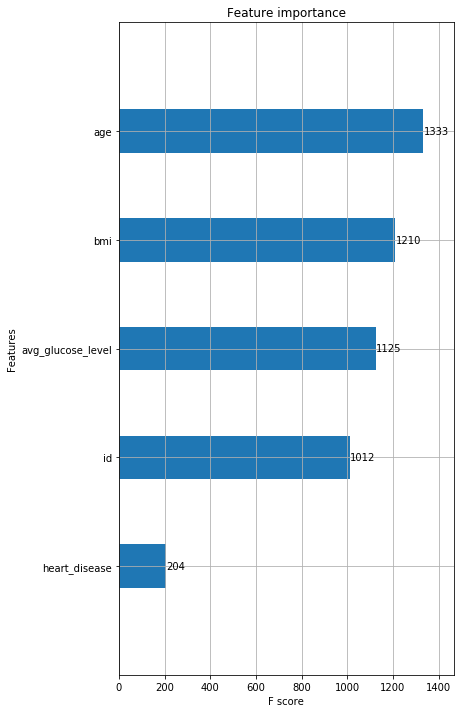

In [244]:
xgb3 = XGBClassifier(learning_rate =0.01, # fixed
                     n_estimators=1000, # now
                     max_depth=3, # tune
                     min_child_weight=5, # tuned 
                     gamma=0., # tuned
                     subsample=0.9, # tuned
                     colsample_bytree=0.6, # tuned
                     objective= 'binary:logistic', 
                     nthread=4, 
                     scale_pos_weight=scale_pos, 
                     seed=1,
                     reg_alpha=100 # tuned
                    )

modelfit(xgb3, x_trn3, y_trn3)

### Final model

In [257]:
xgb4 = XGBClassifier(learning_rate =0.01, # fixed
                     n_estimators=763, # now
                     max_depth=3, # tune
                     min_child_weight=5, # tuned 
                     gamma=0., # tuned
                     subsample=0.9, # tuned
                     colsample_bytree=0.6, # tuned
                     objective= 'binary:logistic', 
                     nthread=4, 
                     scale_pos_weight=scale_pos, 
                     seed=1,
                     reg_alpha=100 # tuned
                    )

In [258]:
xgb4.fit(x_trn3, y_trn3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.0, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
       n_estimators=763, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=100, reg_lambda=1,
       scale_pos_weight=54.427841634738186, seed=1, silent=True,
       subsample=0.9)

In [259]:
preds = xgb4.predict_proba(test_raw[cols])[:,1]

In [260]:
preds.mean()

0.2966617

(array([6867., 1864., 1780., 1660., 1574., 1031., 1123., 1137., 1158.,  407.]),
 array([0.00854, 0.10341, 0.19829, 0.29316, 0.38803, 0.48291, 0.57778, 0.67266, 0.76753, 0.86241, 0.95728]),
 <a list of 10 Patch objects>)

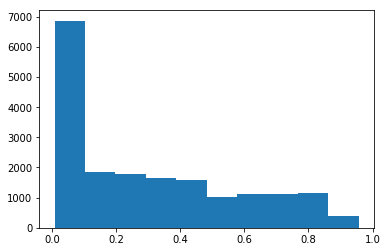

In [261]:
plt.hist(preds)

In [262]:
pred_df = pd.DataFrame(test_raw.id)
pred_df['stroke'] = preds
pred_df.to_csv('submissions/xgb_tuned_select_cols_scaled.csv', index=False)

### XGB by removing some features 

In [187]:
test_raw.shape[0]/train_raw.shape[0]

0.428594470046083

In [191]:
# get validation set to find feature imporanve
x_trn, x_val, y_trn, y_val = train_test_split(train_raw.drop(['stroke', 'age_bins'], axis=1), 
                                                    train_raw['stroke'],
                                                    stratify= train_raw['stroke'] , 
                                                    test_size=0.25,
                                                 random_state=1)

In [192]:
x_trn2 = x_trn.reset_index(drop=True)
x_val2 = x_val.reset_index(drop=True)
y_trn2 = y_trn.reset_index(drop=True)
y_val2 = y_val.reset_index(drop=True)

In [193]:
xgb_feat = XGBClassifier(learning_rate =0.01, # fixed
                     n_estimators=783, # now
                     max_depth=3, # tune
                     min_child_weight=6, # tuned 
                     gamma=0., # tuned
                     subsample=0.9, # tuned
                     colsample_bytree=0.6, # tuned
                     objective= 'binary:logistic', 
                     nthread=4, 
                     scale_pos_weight=scale_pos, 
                     seed=1,
                     reg_alpha=100 # tuned
                    )
xgb_feat.fit(x_trn2, y_trn2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.0, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=6, missing=None,
       n_estimators=783, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=100, reg_lambda=1,
       scale_pos_weight=54.427841634738186, seed=1, silent=True,
       subsample=0.9)

In [199]:
from sklearn.metrics import roc_auc_score
from rfpimp import *


def importances_perm(model, X_valid, y_valid, n_samples=3500):

    if n_samples<0: n_samples = len(X_valid)
    n_samples = min(n_samples, len(X_valid))
    if n_samples<len(X_valid):
        ix = np.random.choice(len(X_valid),n_samples)
        X_valid = X_valid.iloc[ix].copy(deep=False) # shallow copy
        y_valid = y_valid.iloc[ix].copy(deep=False)
    else:
        X_valid = X_valid.copy(deep=False) # we're modifying columns

    baseline = roc_auc_score(y_valid,model.predict_proba(X_valid)[:,1])
    imp = []
    for col in X_valid.columns:
        save = X_valid[col].copy()
        X_valid[col] = np.random.permutation(X_valid[col])
        m = roc_auc_score(y_valid,model.predict_proba(X_valid)[:,1])
        X_valid[col] = save
        imp.append(baseline - m)

    I = pd.DataFrame(data={'Feature': X_valid.columns, 'Importance': np.array(imp)})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I

In [200]:
imp = importances_perm(xgb_feat, x_val2, y_val2, n_samples=len(y_val2)) # permutation

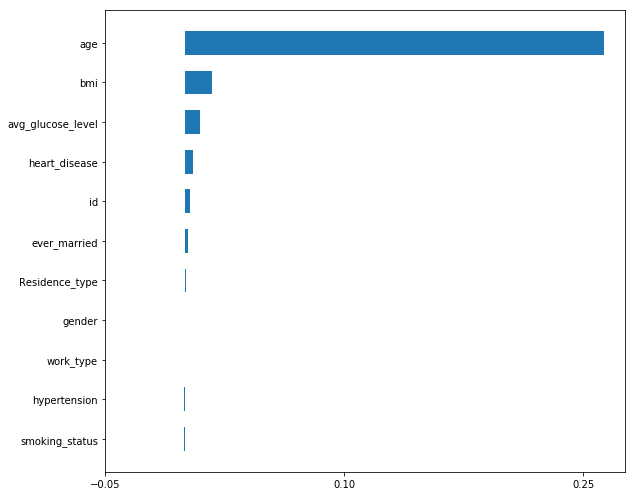

In [201]:
plot_importances(imp, figsize=(15,7))

In [213]:
imp

,Importance
Feature,
smoking_status,-0.000304
hypertension,-0.000105
work_type,0.000310
gender,0.000360
Residence_type,0.000924
ever_married,0.002215
id,0.003658
heart_disease,0.005264
avg_glucose_level,0.009839


In [214]:
cols = list(imp[imp.Importance>0.002].index)

In [215]:
cols

['ever_married', 'id', 'heart_disease', 'avg_glucose_level', 'bmi', 'age']

### Trying only features with +ve importance

In [204]:
xgb_feat.fit(x_trn2[cols], y_trn2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.0, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=6, missing=None,
       n_estimators=783, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=100, reg_lambda=1,
       scale_pos_weight=54.427841634738186, seed=1, silent=True,
       subsample=0.9)

In [206]:
roc_auc_score(y_val2,xgb_feat.predict_proba(x_val2[cols])[:,1])

0.8793343881573654

In [212]:
# experimenting with scale_weight=1

xgb_sc = XGBClassifier(learning_rate =0.01, # fixed
                     n_estimators=783, # now
                     max_depth=3, # tune
                     min_child_weight=6, # tuned 
                     gamma=0., # tuned
                     subsample=0.9, # tuned
                     colsample_bytree=0.6, # tuned
                     objective= 'binary:logistic', 
                     nthread=4, 
                     scale_pos_weight=1, 
                     seed=1,
                     reg_alpha=100 # tuned
                    )
xgb_sc.fit(x_trn2[cols], y_trn2)
roc_auc_score(y_val2,xgb_sc.predict_proba(x_val2[cols])[:,1])

0.8595720013178915

In [207]:
xgb_final = XGBClassifier(learning_rate =0.01, # fixed
                     n_estimators=783, # now
                     max_depth=3, # tune
                     min_child_weight=6, # tuned 
                     gamma=0., # tuned
                     subsample=0.9, # tuned
                     colsample_bytree=0.6, # tuned
                     objective= 'binary:logistic', 
                     nthread=4, 
                     scale_pos_weight=scale_pos, 
                     seed=1,
                     reg_alpha=100 # tuned
                    )

In [208]:
xgb_final.fit(x_trn3[cols], y_trn3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.0, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=6, missing=None,
       n_estimators=783, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=100, reg_lambda=1,
       scale_pos_weight=54.427841634738186, seed=1, silent=True,
       subsample=0.9)

In [209]:
preds = xgb_final.predict_proba(test_raw.drop('age_bins', axis=1)[cols])[:,1]

(array([6835., 1896., 1761., 1638., 1625., 1002., 1098., 1174., 1228.,  344.]),
 array([0.00821, 0.10313, 0.19804, 0.29296, 0.38787, 0.48279, 0.5777 , 0.67262, 0.76753, 0.86245, 0.95736]),
 <a list of 10 Patch objects>)

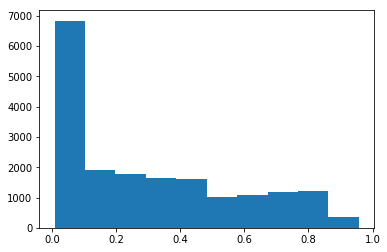

In [210]:
plt.hist(preds)

In [211]:
pred_df = pd.DataFrame(test_raw.id)
pred_df['stroke'] = preds
pred_df.to_csv('submissions/xgb_tuned_perm_imp.csv', index=False)